In [4]:
%matplotlib notebook

In [15]:
from importlib import reload
from typing import Dict, Tuple, List, Union

import numpy as np
from matplotlib import pyplot as plt

In [6]:
import qcodes as qc
from qcodes.instrument.base import Instrument, InstrumentBase
from qcodes.instrument.parameter import Parameter, ArrayParameter

from pytopo.qctools.instruments import create_inst

In [133]:
class StorageParameter(Parameter):

    def __init__(self, *arg, **kw):
        self._value = None
        super().__init__(*arg, **kw)
    
    def get_raw(self):
        return self._value
    
    def set_raw(self, value):
        self._value = value
        

class ArrayStorage(ArrayParameter):
    
    def __init__(self, *arg, **kw):
        self._data = kw.pop('data', np.array([]))
        kw['shape'] = self._data.shape
        super().__init__(*arg, **kw)
        
    def get_raw(self):
        return self._data


class HardSweep(InstrumentBase):
    
    def __init__(self, name: str, **kw):
        super().__init__(name, **kw)
        self._meta_attrs = ['sweep_dims', 'sweep_vals']
        
    def set_sweep_dims(self, sweeps: Dict[str, Union[List, np.ndarray]], units=None):
        self.sweep_dims = []
        self.sweep_vals = []
        self.sweep_shape = []        
        for n, v in sweeps.items():
            self.sweep_dims.append(n)
            self.sweep_vals.append(v)
            self.sweep_shape.append(len(v))
            
        if units is not None:
            self.sweep_units = units
        else:
            self.sweep_units = ['' for s in self.sweep_dims]
        self.sweep_shape = tuple(self.sweep_shape)
        self.sweep_grids = np.meshgrid(*self.sweep_vals, indexing='ij')
        
        self.sweep_params = []
        for i, n in enumerate(self.sweep_dims):
            self.add_parameter(n, parameter_class=ArrayStorage, 
                               data=self.sweep_grids[i].reshape(-1),
                               unit=self.sweep_units[i])
            _p = getattr(self, n)
            self.sweep_params.append(_p)
    
    def setup(self):
        raise NotImplementedError
    
    def get_sweep_coord_zip(self):
        return list(zip(*[s.reshape(-1) for s in self.sweep_grids]))
    
    def get_sweep_coords(self):
        return list(zip(self.sweep_params, [s.reshape(-1) for s in self.sweep_grids]))
        

class HardRabi(HardSweep):
    
    def __init__(self, name: str, **kw):
        super().__init__(name, **kw)
        
        self.add_parameter('start_amp', parameter_class=StorageParameter, 
                           unit='a.u.', initial_value=0)
        self.add_parameter('stop_amp', parameter_class=StorageParameter,
                           unit='a.u.', initial_value=1)
        self.add_parameter('amp_points', parameter_class=StorageParameter,
                           unit='', initial_value=11)
        
        self.add_parameter('start_det', parameter_class=StorageParameter, 
                           unit='Hz', initial_value=-1)
        self.add_parameter('stop_det', parameter_class=StorageParameter,
                           unit='Hz', initial_value=1)
        self.add_parameter('det_points', parameter_class=StorageParameter,
                           unit='', initial_value=11)
        
    def setup(self):
        self.set_sweep_dims(dict(amplitude=np.linspace(self.start_amp(), self.stop_amp(), self.amp_points()),
                                 detuning=np.linspace(self.start_det(), self.stop_det(), self.det_points())),
                            units=[self.start_amp.unit, self.start_det.unit])
        
    def get_dummy_data(self, tvals):
        if type(tvals) not in [list, np.ndarray]:
            tvals = [tvals]
        
        def p(det, amp):
            fr = amp**2 / (det**2 + amp**2)
            return fr * np.cos((det**2 + amp**2)**.5)
        
        p0 = p(self.detuning(), self.amplitude())
        data = np.zeros((p0.size, len(tvals)))
        data = np.outer(p0, np.exp(-tvals))
        return data
        

class HardSweepDetector(Instrument):
    
    def __init__(self, name: str, sweeper: HardSweep, **kw):
        super().__init__(self, name, **kw)
        self.sweeper = sweeper


In [131]:
rabi_swp = HardRabi('rabi_swp')
rabi_swp.start_amp(0)
rabi_swp.stop_amp(20)
rabi_swp.amp_points(51)
rabi_swp.start_det(-20)
rabi_swp.stop_det(20)
rabi_swp.det_points(51)
rabi_swp.setup()

C:\Users\wolfg\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>


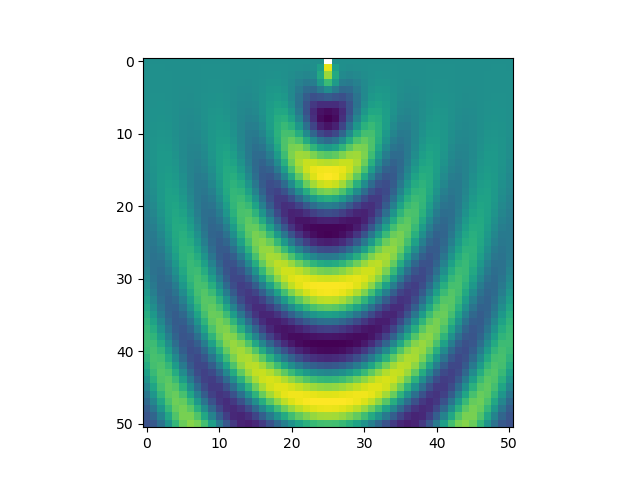

In [134]:
tvals = np.linspace(0, 1, 21)
data = rabi_swp.get_dummy_data(tvals)[:,0].reshape(rabi_swp.sweep_shape)
fig, ax = plt.subplots(1,1)
ax.imshow(data)